In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk

aug_stream_data = load_from_disk("data/processed/aug_stream_data")


In [2]:
from transformers import AutoTokenizer
import torch

model_id = "distilbert-arxiv-domain-adapted"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [3]:
train_dataset = aug_stream_data["train"].map(tokenize, batched=True, batch_size=None)

eval_dataset = aug_stream_data["validation"].map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/1671 [00:00<?, ? examples/s]

In [4]:
labels = aug_stream_data["train"].features["label"].names
y_valid = np.array(eval_dataset["label"])


In [5]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-arxiv-domain-adapted and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/cluster/processing/climate_llm/learn/aa/Advanced-Analytics-03/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
from huggingface_hub import notebook_login
notebook_login()


In [7]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score, f1_score

batch_size = 16
num_train_epochs = 5
learning_rate = 2e-5
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_id}-finetuned-arxiv"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size * 2,weight_decay=0.01,
                                  warmup_steps=500,
                                  fp16=True,
                                  eval_strategy="steps",
                                  eval_steps=500,
                                  save_strategy="steps",
                                  save_total_limit=3,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="macro_f1",
                                  greater_is_better=True,
                                  push_to_hub=True,
                                  label_smoothing_factor=0.1,
                                  log_level="error")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    balanced_accuracy = balanced_accuracy_score(labels, preds)
    return {"macro_f1": macro_f1, "balanced_accuracy": balanced_accuracy}


/cluster/processing/climate_llm/learn/aa/Advanced-Analytics-03/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(train_dataset["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [9]:
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()


Step,Training Loss,Validation Loss,Macro F1,Balanced Accuracy
500,No log,1.219920,0.444831,0.461516
1000,1.945300,1.146930,0.514206,0.604265
1500,1.206600,1.030647,0.634405,0.658004
2000,1.206600,1.079060,0.619749,0.701148
2500,1.004100,1.071663,0.620353,0.698167
3000,0.875000,1.054600,0.640554,0.715965
3500,0.875000,1.062165,0.655842,0.731887


TrainOutput(global_step=3750, training_loss=1.1656162071228027, metrics={'train_runtime': 334.2477, 'train_samples_per_second': 179.328, 'train_steps_per_second': 11.219, 'total_flos': 7942644681523200.0, 'train_loss': 1.1656162071228027, 'epoch': 5.0})

In [10]:
preds_output = trainer.predict(eval_dataset)


In [11]:
preds_output.metrics


{'test_loss': 1.0621646642684937,
 'test_macro_f1': 0.6558422237591269,
 'test_balanced_accuracy': 0.7318871224223911,
 'test_runtime': 2.5583,
 'test_samples_per_second': 653.178,
 'test_steps_per_second': 20.717}

In [12]:
y_preds = np.argmax(preds_output.predictions, axis=1)


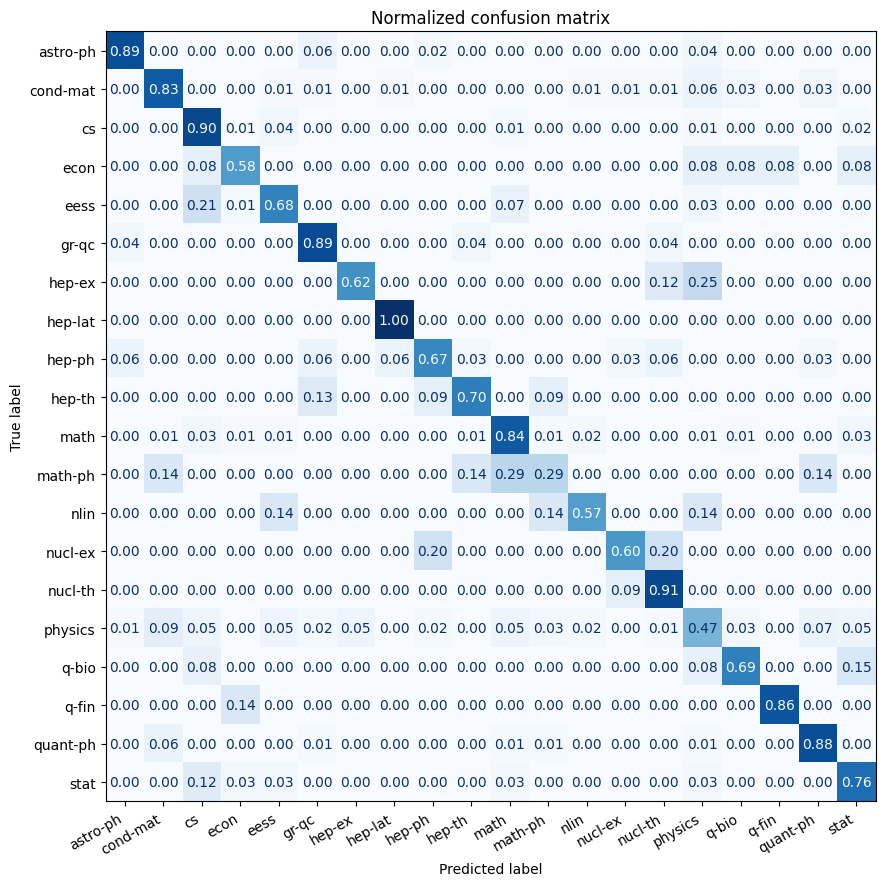

In [13]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_valid, labels)


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)
